# FIFA Players Attribute Analysis
* FIFA database contains player information with detailed attributes.
* A player's overall is determined by a formulation of all the stat points. Used a nonlinear regression model to predict player values.
* Certain attributes may be correlated to other attirbutes. Created heat map to show correlation between stat points.
* Some stat points are more important than others when calculating overall player value. Weights were assigned to stat points to determine its importance.

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import plotly.plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
import cufflinks as cf
import io
from eli5.sklearn import PermutationImportance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import learning_curve, GridSearchCV

### Read Data
* Display first 5 rows of data 

In [2]:
#Read CSV
df = pd.read_csv("data.csv", encoding="ISO-8859-1")

In [3]:
#Take a look at data. Sort by highest overall first
df.sort_values(by=['Overall'], ascending=False, inplace = True)
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
15269,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95,28,31,23,7,11,15,14,11,127.1M
15268,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96,33,28,26,6,11,15,14,8,226.5M
17930,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94,27,24,33,9,9,15,15,11,228.1M
15270,5,183277,E. Hazard,27,https://cdn.sofifa.org/players/4/19/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,91,Chelsea,...,91,34,27,22,11,12,6,8,8,172.1M
3919,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68,15,21,13,90,85,87,88,94,138.6M


### Data Cleaning
* Keep only columns relevant to skill and stat points
* Separate goalkeepers from outfield players

In [4]:
# Remove GK from position 
df = df[df.Position != 'GK']

In [5]:
# Drop unwanted columns
df1 = df.drop(['Unnamed: 0', 'ID', 'Name', 'Photo', 'Nationality', 'Flag', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause'],axis=1)
df1.head()

,Age,Overall,Potential,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
15269,33,94,94,4,5,84,94,89,81,87,...,93,63,29,95,82,85,95,28,31,23
15268,31,94,94,4,4,84,95,70,90,86,...,94,48,22,94,94,75,96,33,28,26
17930,26,92,93,5,5,79,87,62,84,84,...,82,56,36,89,87,81,94,27,24,33
15270,27,91,91,4,4,81,84,61,89,80,...,80,54,41,87,89,86,91,34,27,22
3920,32,91,91,3,3,66,60,91,78,66,...,59,88,90,60,63,75,82,87,92,91


### Machine Learning (Linear)
* Split dataset for machine training.
* Used SKLearn to calculate r-squared value and mean squared error value.
* Used linear regression to predict player rating based on skill points.

In [6]:
X = df1.iloc[:,2:]
y = df1.loc[:,'Overall'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3)
print ("Train dataset sample size: %i" % len(X_train))
print ("Test dataset sample size: %i" % len(X_test))

Train dataset sample size: 11293
Test dataset sample size: 4841


In [7]:
#Applying Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print('r2 : '+str(r2_score(y_test, predictions)))
print('err : '+str(np.sqrt(mean_squared_error(y_test, predictions))))

r2 : 0.8945544017250411
err : 2.222684120738119


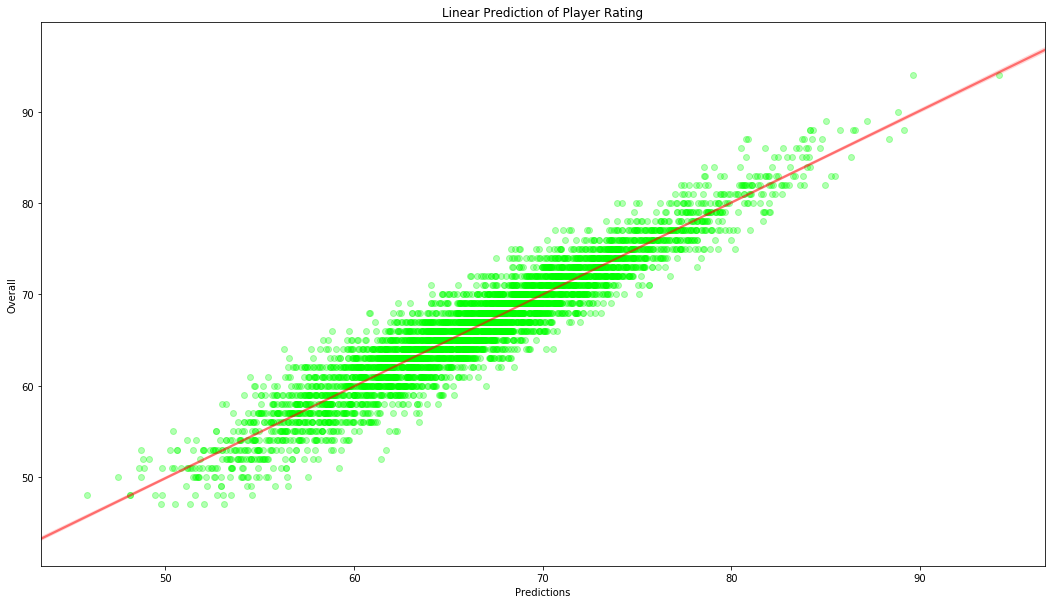

In [8]:
#Visualising the results
plt.figure(figsize=(18,10))
sns.regplot(predictions,y_test,scatter_kws={'alpha':0.3,'color':'lime'},line_kws={'color':'red','alpha':0.5})
plt.xlabel('Predictions')
plt.ylabel('Overall')
plt.title("Linear Prediction of Player Rating")
plt.show()

### Machine Learning (Tuning)
* Linear regression already provides accurate results up to 89% r2 score but can be improved.
* Using XGBoost we can tune our results by adjusting parameters.
* Nonlinear regression provides more accurate results.

In [9]:
#Split data into testing and training sample sizes for machine learning
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')
X = df1.iloc[:,2:]
y = df1.loc[:,'Overall'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3)
print ("Train dataset sample size: %i" % len(X_train))
print ("Test dataset sample size: %i" % len(X_test))

Train dataset sample size: 11293
Test dataset sample size: 4841


In [10]:
# XGBoost tuning parameters
regbgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=1000,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

#Evaluate R-squared and mean squared error
regbgb.fit(X_train,y_train)
p = regbgb.predict(X_test)
r2 = r2_score(y_test, p)
err = mean_squared_error(y_test, p)

print ( 'r2', r2)
print ( 'err', err)

r2 0.9820278584827429
err 0.8420286490150722


In [11]:
# Create overall vs predicted value plot
df_ml = pd.DataFrame({'Predicted Value': p,'Overall Value': y_test}, index= X_test.index).sort_index()
df_ml2 = df.loc[X_test.index]
df_ml3 = pd.merge(df_ml, df_ml2, left_index=True, right_index=True)
df_ml3[['Overall Value','Predicted Value']].iplot(kind='line', xTitle='Player Count', yTitle='Overall Value', world_readable=True)

In [12]:
# Show new dataframe with predicted values
df_ml3.sort_values(by=['Overall Value'], ascending=False, inplace = True)
df_ml3.head(10)

,Predicted Value,Overall Value,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
15268,90.513222,94,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,...,96,33,28,26,6,11,15,14,8,226.5M
15269,91.337753,94,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,...,95,28,31,23,7,11,15,14,11,127.1M
15273,90.463280,90,10,188545,R. Lewandowski,29,https://cdn.sofifa.org/players/4/19/188545.png,Poland,https://cdn.sofifa.org/flags/37.png,90,...,86,34,42,19,15,6,12,8,10,127.1M
3923,86.609802,89,14,215914,N. Kanté,27,https://cdn.sofifa.org/players/4/19/215914.png,France,https://cdn.sofifa.org/flags/18.png,89,...,85,90,91,85,15,12,10,7,10,121.3M
15276,87.078217,89,21,179813,E. Cavani,31,https://cdn.sofifa.org/players/4/19/179813.png,Uruguay,https://cdn.sofifa.org/flags/60.png,89,...,82,52,45,39,12,5,13,13,10,111M
3928,86.836075,88,26,209331,M. Salah,26,https://cdn.sofifa.org/players/4/19/209331.png,Egypt,https://cdn.sofifa.org/flags/111.png,88,...,91,38,43,41,14,14,9,11,14,137.3M
15283,86.349121,88,38,167664,G. Higuaín,30,https://cdn.sofifa.org/players/4/19/167664.png,Argentina,https://cdn.sofifa.org/flags/52.png,88,...,86,35,22,18,5,12,7,5,10,NaN
3933,87.312668,88,34,178603,M. Hummels,29,https://cdn.sofifa.org/players/4/19/178603.png,Germany,https://cdn.sofifa.org/flags/21.png,88,...,91,88,90,88,15,6,10,5,6,75.9M
3929,88.890587,88,27,200145,Casemiro,26,https://cdn.sofifa.org/players/4/19/200145.png,Brazil,https://cdn.sofifa.org/flags/54.png,88,...,84,88,90,87,13,14,16,12,12,126.4M
15281,87.252983,88,33,188567,P. Aubameyang,29,https://cdn.sofifa.org/players/4/19/188567.png,Gabon,https://cdn.sofifa.org/flags/115.png,88,...,86,27,25,36,6,9,15,9,9,112.1M


### Data Correlation
* Create correlation matrix with desired attribute columns.
* Generate a correlation heatmap with plotly

In [13]:
#Creating correlation reference
corr = df1[df1.columns[:]].corr()

In [14]:
fig = corr.iplot(kind='heatmap', colorscale='RdBu')

### Weight
* Assigned weights to stat points based on how much it affects overall rating

In [15]:
#Find which stat points most affect the overall rating
weights = pd.Series(100*regbgb.feature_importances_,index=X_train.columns).sort_values()
weights.iplot(kind='bar', yTitle='%', world_readable=True, title='Stat Point Weight')